In [5]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

warnings.filterwarnings('ignore')

In [14]:
df_2020 = pd.read_csv('user_2020.csv')
df_2020['create_date'] = pd.to_datetime(df_2020['create_date'])

In [15]:
df_2020.head()

,user_id,order_no,paid_cash,create_date
0,452485,202302160072007,300.0,2023-02-16
1,452494,202101090070492,9.0,2021-01-09
2,452494,202101130075871,90.0,2021-01-13
3,452498,202202060858935,300.0,2022-02-06
4,452498,202212100040463,99.0,2022-12-10


In [17]:
df_rfmt = summary_data_from_transaction_data(df_2020,
                                            'user_id',
                                            'create_date',
                                            'paid_cash',
                                            observation_period_end='2023-9-20')
df_rfmt.head()

,frequency,recency,T,monetary_value
user_id,,,,
452485,0.0,0.0,216.0,0.0
452494,1.0,4.0,984.0,90.0
452498,6.0,1043.0,1327.0,198.0
452500,1.0,48.0,960.0,1.0
452501,0.0,0.0,533.0,0.0


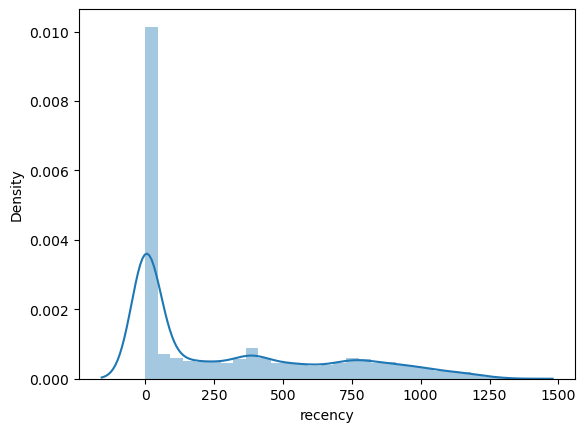

In [18]:
ax = sns.distplot(df_rfmt['recency'])

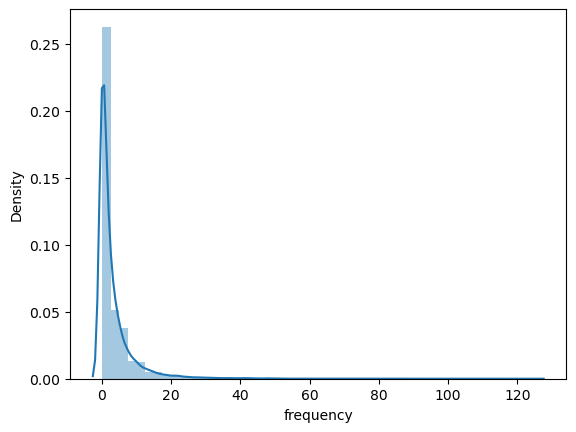

In [19]:
ax = sns.distplot(df_rfmt['frequency'])

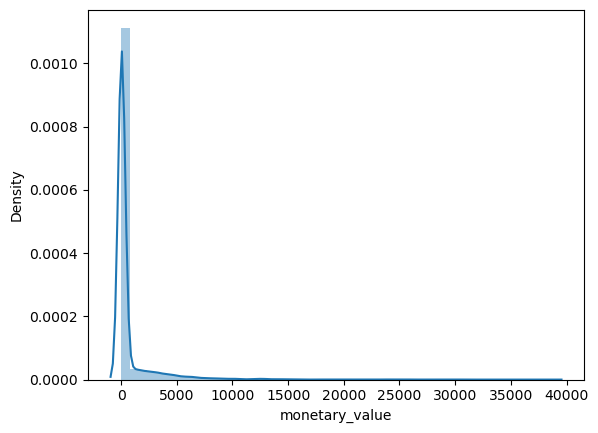

In [20]:
ax = sns.distplot(df_rfmt['monetary_value'])

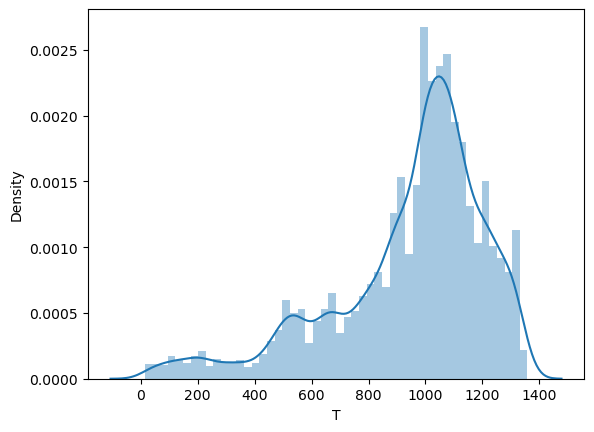

In [21]:
ax = sns.distplot(df_rfmt['T'])

In [22]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.310478,0.004697,0.301272,0.319684
alpha,34.800757,0.946450,32.945715,36.655798
a,1.789791,0.121622,1.551412,2.028170
b,9.934030,0.856150,8.255976,11.612085


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

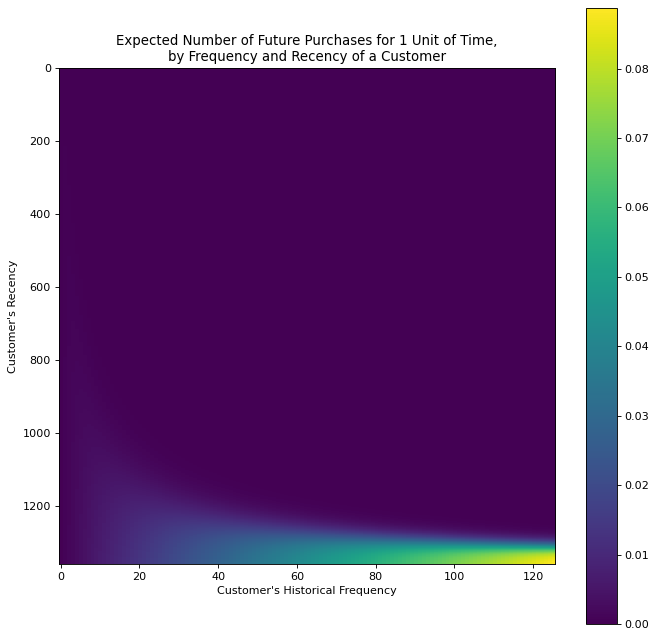

In [23]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

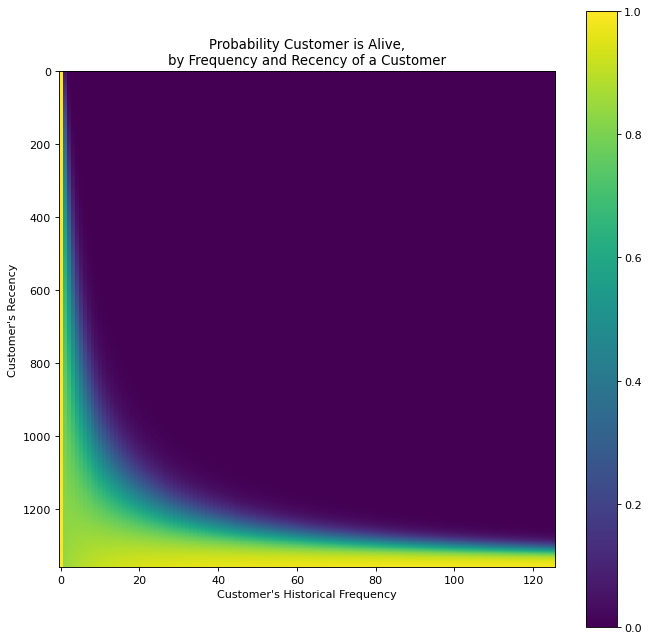

In [24]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plot_probability_alive_matrix(bgf)

In [28]:
t = 90
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])


In [29]:
df_rfmt.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
496438,53.0,1165.0,1190.0,832.102453,3.416487
467282,74.0,1228.0,1277.0,621.261757,3.543473
472674,69.0,1049.0,1097.0,679.209565,3.548026
538189,48.0,1005.0,1024.0,302.619792,3.593470
535795,49.0,960.0,988.0,310.917143,3.632822
471470,51.0,965.0,993.0,191.316078,3.755424
523946,11.0,95.0,113.0,334.609091,3.841290
462750,64.0,1187.0,1207.0,801.184687,4.126813
522080,65.0,1051.0,1079.0,1074.374462,4.405225


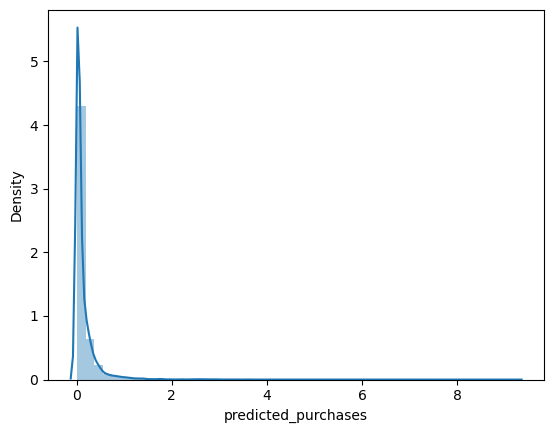

In [30]:
ax = sns.distplot(df_rfmt['predicted_purchases'])

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

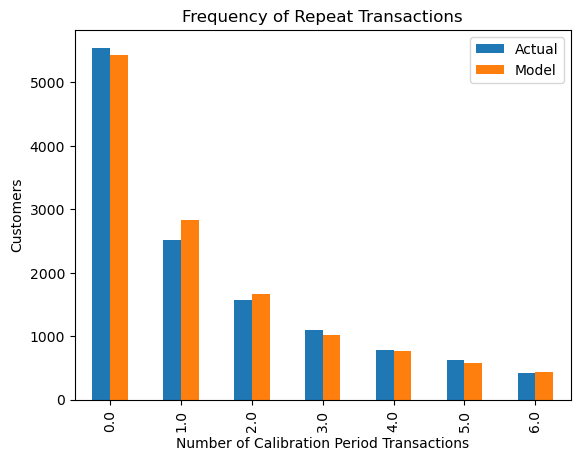

In [31]:
plot_period_transactions(bgf)

In [33]:
summary_cal_holdout = calibration_and_holdout_data(df_2020, 
                                                   'user_id', 
                                                   'create_date',
                                                    calibration_period_end='2023-6-20',
                                                    observation_period_end='2023-9-20')

In [34]:
summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
519994,111.0,918.0,918.0,14.0,92.0
523946,1.0,19.0,21.0,10.0,92.0
500374,5.0,961.0,1078.0,6.0,92.0
541972,3.0,625.0,895.0,6.0,92.0
544094,24.0,867.0,901.0,6.0,92.0


In [35]:
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 14542 subjects, a: 1.53, alpha: 33.85, b: 8.51, r: 0.31>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

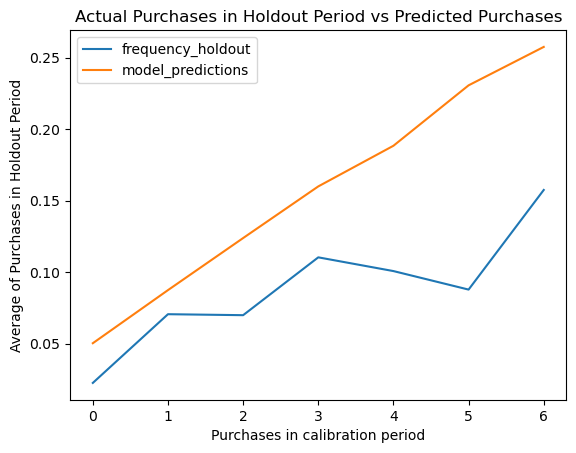

In [36]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [37]:
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

summary_cal_holdout = calibration_and_holdout_data(df_2020, 
                                                   'user_id', 
                                                   'create_date',
                                                    calibration_period_end='2020-9-20',
                                                    observation_period_end='2023-9-20')

bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 4469 subjects, a: 6.59, alpha: 5.85, b: 15.04, r: 0.19>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

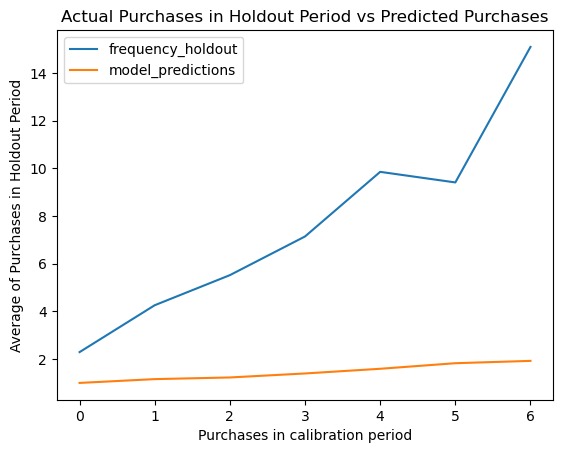

In [38]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [39]:
t = 365
individual = df_rfmt.iloc[1]
bgf.predict(t, 
            individual['frequency'], 
            individual['recency'], 
            individual['T'])

0.0036613449892861664

In [40]:
example_customer_orders = df_2020.loc[df_2020['user_id'] == 452498]
example_customer_orders

,user_id,order_no,paid_cash,create_date
3,452498,202202060858935,300.0,2022-02-06
4,452498,202212100040463,99.0,2022-12-10
5,452498,202109010700916,9.0,2021-09-01
6,452498,202002010733529,300.0,2020-02-01
7,452498,202102060100213,300.0,2021-02-06
8,452498,202009160878220,480.0,2020-09-16
9,452498,202009300898534,0.0,2020-09-30


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

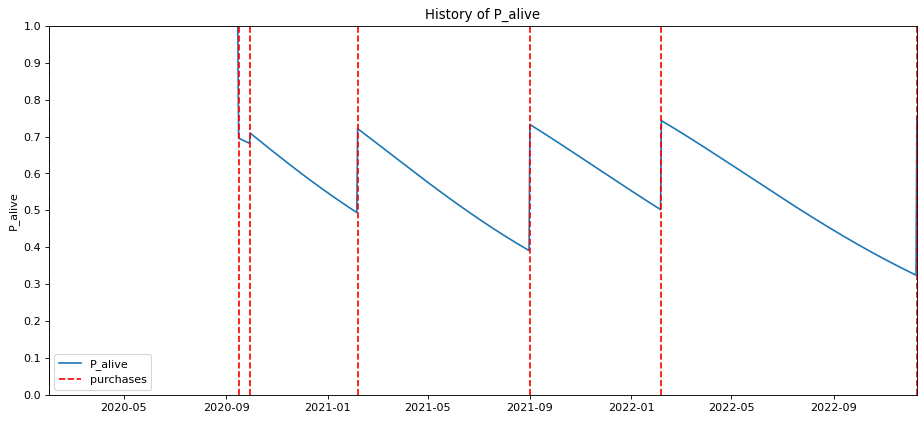

In [41]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 118
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'create_date')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

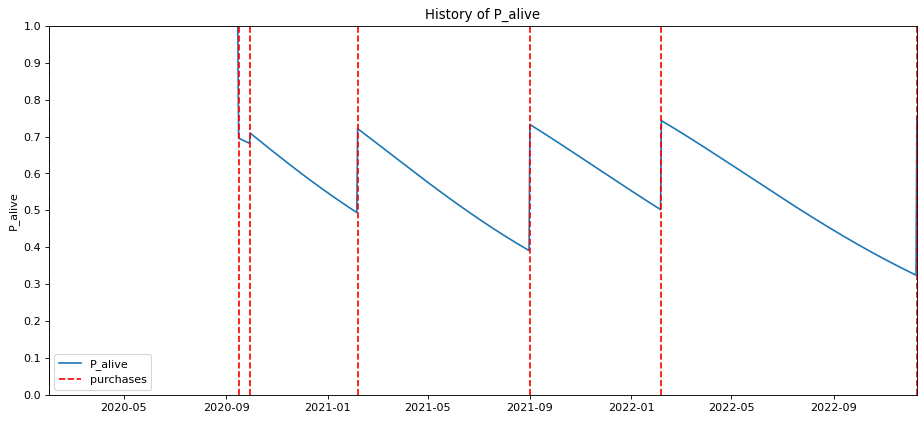

In [42]:
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 182
plot_history_alive(bgf, days_since_birth, example_customer_orders, 'create_date')

In [43]:
returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
456131,1.0,1.0,1277.0,38600.0,0.004196
473046,1.0,6.0,1282.0,38600.0,0.004894
495578,1.0,38.0,924.0,30600.0,0.019286
520635,1.0,45.0,986.0,30600.0,0.018721
536152,1.0,6.0,1034.0,29608.8,0.007772


In [44]:
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.046429
frequency,0.046429,1.000000


In [45]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 8893 subjects, p: 0.68, q: 0.63, v: 83.89>

In [46]:
predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
)

In [47]:
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)

In [48]:
aov_df.head(5)

,aov
user_id,
473046,84138.309382
456131,84138.309382
520635,66738.134646
495578,66738.134646
536152,64582.252996


In [49]:
aov_df.tail(5)

,aov
user_id,
459223,14.329096
508043,11.865138
461346,11.571444
510478,11.497293
536504,6.978870


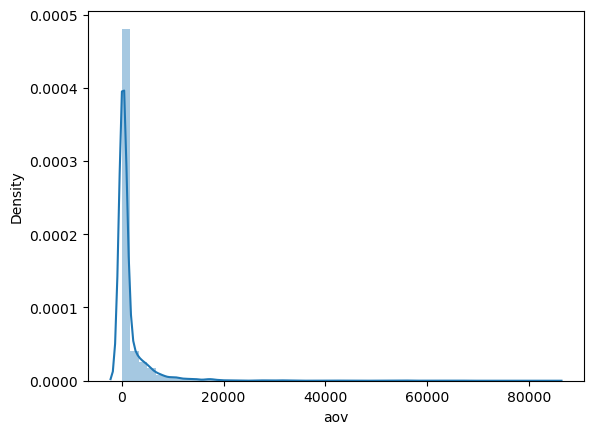

In [50]:
ax = sns.distplot(aov_df['aov'])

In [51]:
aov_df['aov_bin'] = pd.qcut(aov_df['aov'], q=5, labels=[1, 2, 3, 4, 5])
aov_df = aov_df.reset_index()

In [52]:
aov_df.groupby('aov_bin').agg(
    count=('user_id', 'count'),
    min_aov=('aov', min),
    max_aov=('aov', max),
    std_aov=('aov', 'std'),    
    aov=('aov', 'mean')
).sort_values(by='aov')

,count,min_aov,max_aov,std_aov,aov
aov_bin,,,,,
1,1781,6.978870,94.273905,17.989519,64.705523
2,1783,94.399975,193.341388,30.731523,142.504072
3,1772,193.395064,335.174955,40.513156,256.024302
4,1778,335.185660,1530.111089,322.037433,660.932133
5,1779,1531.060274,84138.309382,8332.272267,6665.327405


In [53]:
from sklearn.cluster import KMeans

aov_clusters = aov_df[['aov']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(aov_clusters)

aov_clusters = aov_clusters.assign(cluster=kmeans.labels_)
aov_clusters.groupby('cluster')['aov'].mean().sort_values(ascending=False).to_frame()

,aov
cluster,
1,58085.546409
4,31536.342875
2,13435.679718
3,4835.053569
0,384.406051


In [54]:
bgf.fit(returning_customers['frequency'], 
        returning_customers['recency'], 
        returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 8893 subjects, a: 1.58, alpha: 107.37, b: 7.54, r: 1.34>

In [55]:
preds = ggf.customer_lifetime_value(
    bgf,
    returning_customers['frequency'],
    returning_customers['recency'],
    returning_customers['T'],
    returning_customers['monetary_value'],
    time = 12,
    discount_rate = 0.01
)

preds = preds.to_frame().reset_index()

In [56]:
preds.sort_values(by='clv', ascending=False).head()

,user_id,clv
6724,519994,465632.851195
8663,542682,100761.517059
3721,491876,95543.624691
2160,478222,85656.184039
6186,515351,44872.338681


In [57]:
preds.sort_values(by='clv', ascending=False).tail()

,user_id,clv
3168,486641,1.367152e-08
707,460453,6.550578e-09
769,461346,2.032359e-09
7401,526506,9.244241e-10
5768,511295,7.296577e-11
